### add more dimensions

in the simple bigram model our letters just had an integer index

this time lets say they inhabit a 2 dimensional space, and we can move them around in that space as we train

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [2]:
vocab_size = 27
embedding_size = 2
# our embedding space
es = torch.randn((vocab_size, embedding_size))

In [3]:
# show the embedding space an the 'a' co-ordinates (Transpose es just to save display space)
es.T, es[1]

(tensor([[ 4.3062e-01,  5.4110e-01, -1.6214e-03, -4.4682e-01, -1.1512e-03,
          -2.9799e-01,  4.0123e-01,  1.2259e+00, -1.9038e+00,  1.4593e+00,
          -4.5409e-01,  1.2814e+00,  1.1369e+00, -7.5805e-03,  1.1151e+00,
           6.6272e-01,  1.5688e+00, -5.7599e-01, -9.1451e-01, -2.7337e-01,
           9.4394e-01,  7.6154e-01, -1.0951e+00,  3.3686e-01,  5.8808e-01,
           1.0283e+00, -2.3396e-01],
         [ 8.2388e-01,  2.0297e+00,  4.3256e-01,  1.8258e+00, -1.7869e+00,
           3.2054e-01, -8.5015e-01, -4.1018e-01, -5.2823e-01, -5.4173e-01,
          -1.9819e+00,  1.2371e+00,  2.1639e-01, -1.7835e+00,  5.1852e-01,
           5.7749e-01,  1.9405e-01,  1.3953e+00,  1.7460e-01, -3.0110e-01,
          -1.3262e+00,  9.2883e-01, -1.1268e+00,  1.3561e+00, -3.9672e-01,
          -2.9362e+00, -3.1789e-01]]),
 tensor([0.5411, 2.0297]))

In [4]:
x = torch.tensor(5)
rep = F.one_hot(x, num_classes=vocab_size).float()
rep @ es

tensor([-0.2980,  0.3205])

In [5]:
with open("names.txt", "r") as r:
    names = ["." + f + "." for f in r.read().split()]

import string
letters = [l for l in string.ascii_lowercase]

itos = {0: "."}
stoi = {".": 0}

for i, l in enumerate(letters):
    offset = i+1
    stoi[l] = offset
    itos[offset] = l


In [6]:
stoi['a'], len(names)

(1, 32033)

In [7]:
from random import randrange

names_length = len(names)

def sample_names(size=5):
    batch_names = []
    for i in range(size):
        ni = randrange(names_length-1)
        name = names[ni]
        batch_names.append(name)
    return batch_names

sample_names(2)

['.lenzie.', '.ellarose.']

In [8]:
def get_xys(samples):
    xs, ys = [], []
    for s in samples:
        em = [stoi[c] for c in s] 
        for x, y in zip(em, em[1:]):
            xs.append(x)
            ys.append(y)

    return xs, ys

In [9]:
x, y = get_xys(sample_names(2))
x, y

([0, 11, 25, 1, 8, 0, 13, 9, 11, 5, 12, 12, 5],
 [11, 25, 1, 8, 0, 13, 9, 11, 5, 12, 12, 5, 0])

In [10]:
es[x], es[10]

(tensor([[-1.1133,  0.4170],
         [-0.3114,  0.3001],
         [-0.4415, -1.3682],
         [ 0.3683,  0.4668],
         [-2.3022, -0.4260],
         [ 0.3859, -0.1330],
         [ 0.3683,  0.4668],
         [-1.1133,  0.4170],
         [ 0.9573, -2.1338],
         [ 0.3859, -0.1330],
         [-0.9595,  1.0326],
         [-2.3022, -0.4260],
         [-0.4415, -1.3682],
         [ 0.3683,  0.4668]]),
 tensor([-0.5353,  1.8641]))

In [11]:
train = es[x]
train.shape

torch.Size([14, 2])

In [12]:
W = torch.randn(2, 100)
b = torch.randn(100)

In [13]:
outputL1 = torch.tanh(train @ W + b)
outputL1.shape

torch.Size([14, 100])

In [14]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [15]:
logits = outputL1 @ W2 + b2
logits.shape

torch.Size([14, 27])

In [102]:
probs = logits.exp()
probs.shape, labels.shape, probs, labels
# loss = -probs[y].sum(1).log().mean()
loss = - probs.T[y].log().mean()

## OK lets run this and see what happens...

In [217]:
es = torch.randn((27, 2), requires_grad=True)
W = torch.randn((2, 100), requires_grad=True)
b = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [es, W, b, W2, b2]

In [216]:
names_length = len(names)
epochs = 70
batch_size = 200
learning_rate = 2
samples = 400 #in future we want our epoch to roughly sample everything - names_length / batch_size

In [218]:
for ep in range(epochs):
    epoch_loss = 0
    for s in range(samples):
        x, y = get_xys(sample_names(batch_size))
        Y = torch.tensor(y)
        train = es[x]
        outputL1 = torch.tanh(train @ W + b)
        logits = outputL1 @ W2 + b2

        loss = F.cross_entropy(logits, Y)

        epoch_loss += loss

        es.grad = None
        W.grad = None
        b.grad = None
        W2.grad = None
        b2.grad = None
        
        loss.backward()
        es.data -=learning_rate * es.grad
        W.data -= learning_rate * W.grad
        b.data -= learning_rate * b.grad
        W2.data -= learning_rate * W2.grad
        b2.data -= learning_rate * b2.grad
    print(epoch_loss/samples)
    learning_rate *= .95
    print(ep, learning_rate)

tensor(17.1653, grad_fn=<DivBackward0>)
0 1.9
tensor(10.3963, grad_fn=<DivBackward0>)
1 1.805
tensor(8.4369, grad_fn=<DivBackward0>)
2 1.7147499999999998
tensor(6.6895, grad_fn=<DivBackward0>)
3 1.6290124999999998
tensor(5.8348, grad_fn=<DivBackward0>)
4 1.5475618749999998
tensor(5.0832, grad_fn=<DivBackward0>)
5 1.4701837812499996
tensor(4.3988, grad_fn=<DivBackward0>)
6 1.3966745921874995
tensor(3.7966, grad_fn=<DivBackward0>)
7 1.3268408625781245
tensor(3.3958, grad_fn=<DivBackward0>)
8 1.2604988194492182
tensor(3.1424, grad_fn=<DivBackward0>)
9 1.1974738784767571
tensor(2.9672, grad_fn=<DivBackward0>)
10 1.1376001845529191
tensor(2.8372, grad_fn=<DivBackward0>)
11 1.080720175325273
tensor(2.7635, grad_fn=<DivBackward0>)
12 1.0266841665590094
tensor(2.6985, grad_fn=<DivBackward0>)
13 0.9753499582310589
tensor(2.6609, grad_fn=<DivBackward0>)
14 0.9265824603195059
tensor(2.6173, grad_fn=<DivBackward0>)
15 0.8802533373035305
tensor(2.5961, grad_fn=<DivBackward0>)
16 0.8362406704383539


In [143]:
def generate_names(num_names):
    for i in range(num_names):
        out = []
        ix = 0
        for nl in range(20):
            xenc = es[ix]
            
            outputL1 = torch.tanh(xenc @ W + b)
            logits = outputL1 @ W2 + b2
            
            counts = logits.exp()
            
            p = counts / counts.sum(0, keepdim=True)
    
            ## torch.multinomial pulls out an index in p (num_samples=1) by sampling from the elements in p according to their probabilities 
            ## (p is normalized in the softmax above)
            ix = torch.multinomial(p, num_samples=1).item()
    
            if ix == 0:
                break
            out.append(itos[ix])
            
        print("".join(out))

In [178]:
generate_names(10)

jaiesaeriin
ja
j
karya
jazya
dellheli
heeinlien
s
lsharo
ma


In [46]:
import matplotlib.pyplot as plt

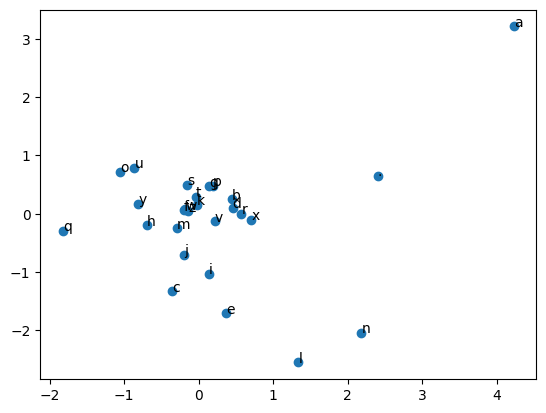

In [219]:
x = es.T[0].tolist()
y = es.T[1].tolist()
n = ['.'] + letters

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

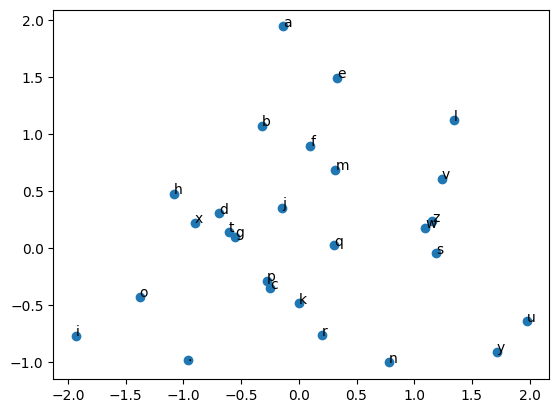

In [215]:
x = es.T[0].tolist()
y = es.T[1].tolist()
n = ['.'] + letters

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

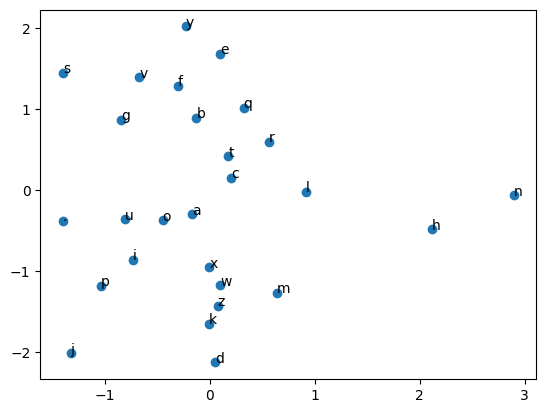

In [208]:
x = es.T[0].tolist()
y = es.T[1].tolist()
n = ['.'] + letters

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

In [220]:
import numpy as np

In [236]:
r = np.arange(.001, 1, .01)

In [224]:
import math

In [237]:
re = [math.log(e) for e in r]

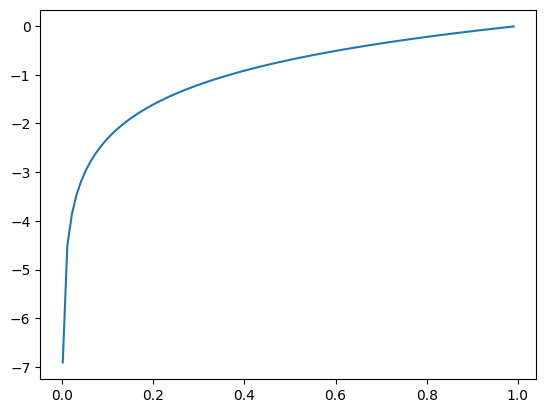

In [238]:
plt.plot(r, re)

In [246]:
e = np.arange(-7, 0, .01)

In [247]:
y = [math.exp(x) for x in e]

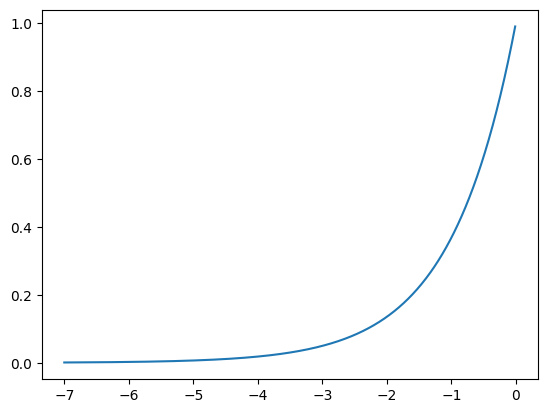

In [248]:
plt.plot(e, y)